In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import stats
from math import sqrt, exp
import seaborn as sns
%matplotlib inline

# データ説明
filenameはfile名<br>
trueは実際のクラス番号（この中で、0は正常、その他は異常）<br>
predictはAI予想のクラス番号<br>
00-06までは各クラスのAIが予測した出力<br>
tbはtrueが0なら0、その他なら1 (つまり、正常なら0、異常なら1)<br>
pbはAI予想の正常異常タグ<br>
over01は01-06の合計、つまりAIが予測した異常確率<br>
over02は02-06の合計、相関係数の算出にて使う<br>

In [82]:
df = pd.read_csv("data2.csv")
df.head()

,filename,true,predict,00,01,02,03,04,05,06,tb,pb,over01,over02
0,0,5,3,0.000003,0.002729,0.000424,0.531146,0.080503,0.384158,0.001035,1,1,0.999997,0.997267
1,1,2,2,0.054342,0.023169,0.529376,0.037848,0.083393,0.058237,0.213634,1,1,0.945658,0.922489
2,2,2,2,0.008336,0.042994,0.670757,0.021298,0.047873,0.013001,0.195741,1,1,0.991664,0.948670
3,3,4,6,0.046755,0.004052,0.108306,0.009291,0.039530,0.164362,0.627703,1,1,0.953245,0.949193
4,4,3,3,0.000002,0.000069,0.002111,0.990379,0.001681,0.004340,0.001418,1,1,0.999998,0.999929


### 2クラス分類 (tb, over01)
1) AUC <br>
2) ROC曲線 <br>
3) 感度・特異度 (over01 > 0.5と実際の回答で比較) <br>

##### 1) AUC

In [83]:
def roc_auc_ci(y_true, y_score, digit = 3, alpha = 0.95):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == 1)
    N2 = sum(y_true != 1)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    ratio = 0.5 + 0.5 * alpha
    lower = AUC - stats.norm.ppf(ratio) *SE_AUC
    upper = AUC + stats.norm.ppf(ratio) *SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return round(AUC,digit), (round(lower,digit), round(upper, digit))

In [84]:
roc_auc_ci(df["tb"], df["over01"])

(0.98, (0.957, 1))

##### 2) ROC曲線

(0, 1.02)

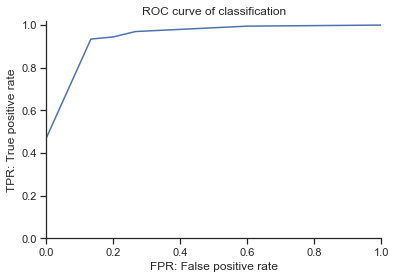

In [94]:
fpr, tpr, thresholds = roc_curve(df["tb"], df["over01"])
sns.set_style("ticks")
sns.lineplot(x=fpr, y=tpr, ci=None)
sns.despine()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.title("ROC curve of classification")
plt.xlim(0, 1.0)
plt.ylim(0, 1.02)
# plt.savefig("ROC_curve.png")

##### 3) 感度・特異度

In [40]:
def clopper_pearson(k, n, digit, alpha = 0.95):
    alpha2 = (1 - alpha) / 2
    lower = stats.beta.ppf(alpha2, k, n - k + 1)
    upper = stats.beta.ppf(1 - alpha2, k + 1, n - k)
    return k, n, round(k/n, digit), (round(lower,digit), round(upper, digit))

In [44]:
def sen_spe_ci_score(y_true, y_score, digit = 3, alpha = 0.95):
    n1 = np.sum(y_true == 1)
    k1 = len(np.intersect1d(np.where(y_true == 1), np.where(y_score >= 0.5)))
    n0 = np.sum(y_true == 0)
    k0 = len(np.intersect1d(np.where(y_true == 0), np.where(y_score < 0.5)))
    return clopper_pearson(k1, n1, digit, alpha), clopper_pearson(k0, n0, digit, alpha) 

In [45]:
sen_spe_ci_score(df["tb"], df["over01"])

((93, 99, 0.939, (0.873, 0.977)), (12, 15, 0.8, (0.519, 0.957)))

### 多クラス分類
1) AUC <br>
2) ROC曲線 <br>
ここまでは上に同じ <br>
3) 感度・特異度 (AIの回答と実際の回答で比較) <br>
4) 各クラスの正答率のCI <br>
5) クロス集計表 <br>
6) Color map <br>

##### 3) 感度・特異度

In [49]:
def clopper_pearson(k, n, digit, alpha = 0.95):
    alpha2 = (1 - alpha) / 2
    lower = stats.beta.ppf(alpha2, k, n - k + 1)
    upper = stats.beta.ppf(1 - alpha2, k + 1, n - k)
    return k, n, round(k/n, digit), (round(lower,digit), round(upper, digit))

In [47]:
def sen_spe_ci_predict(y_true, y_predict, digit = 3, alpha = 0.95):
    n1 = np.sum(y_true == 1)
    k1 = len(np.intersect1d(np.where(y_true == 1), np.where(y_predict == 1)))
    n0 = np.sum(y_true == 0)
    k0 = len(np.intersect1d(np.where(y_true == 0), np.where(y_predict == 0)))
    return clopper_pearson(k1, n1, digit, alpha), clopper_pearson(k0, n0, digit, alpha) 

In [48]:
sen_spe_ci_predict(df["tb"], df["pb"])

((92, 99, 0.929, (0.86, 0.971)), (14, 15, 0.933, (0.681, 0.998)))

##### 4) 各クラスの正答率

In [53]:
def class_ci(y_true, y_predict, target, digit = 3, alpha = 0.95):
    n = np.sum(y_true == target)
    k = len(np.intersect1d(np.where(y_true == target), np.where(y_predict == target)))
    return clopper_pearson(k, n, digit, alpha)

In [54]:
n_classes = 7
for n in range(n_classes):
    print(n, class_ci(df["true"], df["predict"], n))

0 (14, 15, 0.933, (0.681, 0.998))
1 (24, 28, 0.857, (0.673, 0.96))
2 (12, 20, 0.6, (0.361, 0.809))
3 (5, 11, 0.455, (0.167, 0.766))
4 (6, 18, 0.333, (0.133, 0.59))
5 (0, 8, 0.0, (nan, 0.369))
6 (8, 14, 0.571, (0.289, 0.823))


##### 5) クロス集計表

In [59]:
cols =  ["00", "01", "02", "03", "04", "05", "06"]
dic = {}
for i, col in enumerate(cols):
    dic[i] = col
cross = pd.crosstab(df["predict"], df["true"])
cross = cross.rename(columns=dic)
cross = cross.rename(index=dic)
cross

true,00,01,02,03,04,05,06
predict,,,,,,,
00,14,1,0,1,0,2,3
01,0,24,0,0,3,0,1
02,0,1,12,0,0,0,2
03,0,0,2,5,5,2,0
04,0,1,2,1,6,1,0
05,1,1,3,3,0,0,0
06,0,0,1,1,4,3,8


##### 6) Color Map

In [63]:
# 比率によるクロス集計表を作成
cols =  ["00", "01", "02", "03", "04", "05", "06"]
dic = {}
for i, col in enumerate(cols):
    dic[i] = col
cross = pd.crosstab(df["predict"], df["true"], normalize="columns")
cross = cross.rename(columns=dic)
cross = cross.rename(index=dic)
cross

true,00,01,02,03,04,05,06
predict,,,,,,,
00,0.933333,0.035714,0.00,0.090909,0.000000,0.250,0.214286
01,0.000000,0.857143,0.00,0.000000,0.166667,0.000,0.071429
02,0.000000,0.035714,0.60,0.000000,0.000000,0.000,0.142857
03,0.000000,0.000000,0.10,0.454545,0.277778,0.250,0.000000
04,0.000000,0.035714,0.10,0.090909,0.333333,0.125,0.000000
05,0.066667,0.035714,0.15,0.272727,0.000000,0.000,0.000000
06,0.000000,0.000000,0.05,0.090909,0.222222,0.375,0.571429


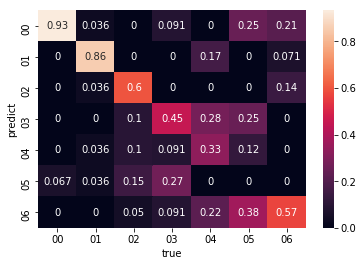

In [62]:
sns.heatmap(cross, annot=True)
# plt.savefig("crosstab.png")

### 回帰
1) plot <br>
2) 相関係数<br>

今回はデータセットの都合上、over01とover02の相関について議論する

##### 1) plot

(0, 1.02)

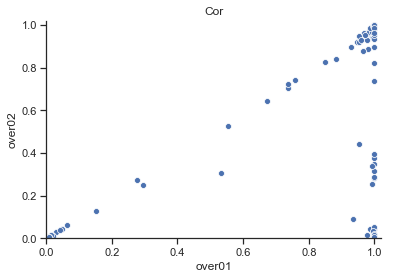

In [98]:
fpr, tpr, thresholds = roc_curve(df["tb"], df["over01"])
sns.set_style("ticks")
sns.scatterplot(data=df, x='over01', y='over02')
sns.despine()
plt.title("Cor")
plt.xlim(0, 1.02)
plt.ylim(0, 1.02)
# plt.savefig("ROC_curve.png")

##### 2) 相関係数

In [101]:
def corr_CI(a, b, alpha = 0.95):
    r = stats.pearsonr(a, b)[0]
    n = len(a)
    if n <= 3:
        AssertionError("Not enough amount data")
    z= 0.5*np.log((1+r)/(1-r))
    za = stats.norm.ppf(0.5 + 0.5 * alpha) 
    zl = z - za * sqrt(1/(n-3))
    zu = z + za * sqrt(1/(n-3))
    rhol = (exp(2 * zl) - 1 )/ (exp(2 * zl) +1 )
    rhou = (exp(2 * zu) - 1 )/ (exp(2 * zu) +1 )
    return r, rhol, rhou

In [103]:
corr_CI(df["over01"], df["over02"])

(0.5495549338116301, 0.40675097591900805, 0.6661419155573262)